<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Part 1: Camera Calibration</p><br>

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Import Libraries
</p>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as maimg
import glob 
import pickle
import os
from collections import deque
%matplotlib inline

import matplotlib.image as mpimage


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Carmera Calibration Function
</p>

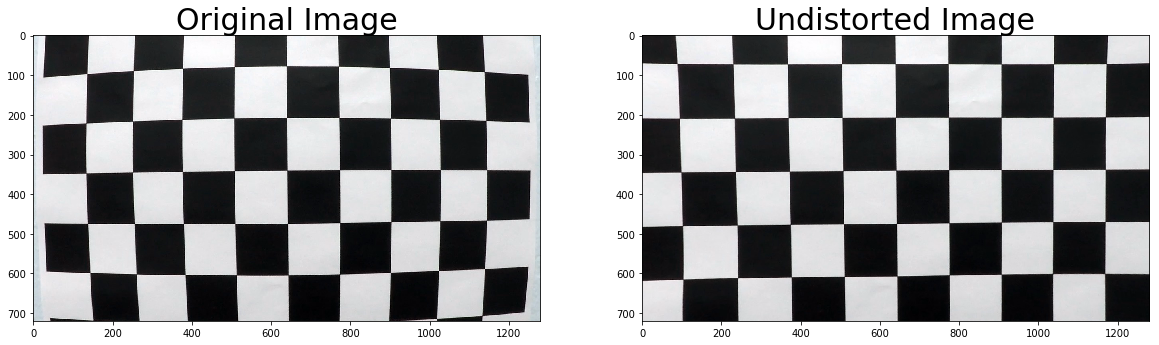

In [2]:
def camera_calibration(nx, ny, imgs_path='camera_cal/calibration*.jpg'):
    """
    Return camera calibration matrix
    
    imgs_path:chessboard images in given glob path
    nx: the number of corners
    ny: the range of ny list
    """
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    imgs = glob.glob(imgs_path)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
            
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(imgs):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img_size = img.shape[0:2]

            # Draw and display the corners
            """
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = output_path+'corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)
            """
            
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return mtx, dist

def test_undistortion():
    """
    Test undistortion on an image
    """
    img = cv2.imread('camera_cal/calibration1.jpg')
    # Call the Carmera Calibration Function
    mtx, dist = camera_calibration(nx=9, ny=6)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Show the original image and undistored img
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)

test_undistortion()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
</p>

In [3]:
def save_calibration_result():
    """
    Save the camera calibration result
    """
    dist_pickle = {}
    mtx, dist = camera_calibration(nx=9, ny=6)
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "calibration_pickle.p", "wb" ) )

save_calibration_result()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Use the the camera calibration result file("calibration_pickle.p")
</p>

In [4]:
def use_calibration_result(imgs_path='camera_cal/calibration*.jpg', out_path='output_images/part1/'):
    """
    Use the camera calibration result
    """
    # load pickled distortion matrix
    with open('calibration_pickle.p', mode='rb') as f:
        dist_pickle = pickle.load(f)
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
    
    # Make a list of calibration images
    imgs = glob.glob(imgs_path)
    
    # Step through the list and calibrate the images of "camera_cal" directory
    for idx, fname in enumerate(imgs):
        img = cv2.imread(fname)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        
        if not os.path.exists(out_path):
            os.makedirs(out_path)
            write_name = out_path+'undistorted_calibration'+str(idx)+'.jpg'
        else:
            write_name = out_path+'undistorted_calibration'+str(idx)+'.jpg'
            
        cv2.imwrite(write_name, dst)
        cv2.imshow('img', dst)
        cv2.waitKey(500)
    cv2.destroyAllWindows()

use_calibration_result()

<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Part 2: Pipeline (single images)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

1. Provide an example of a distortion-corrected image
</p>

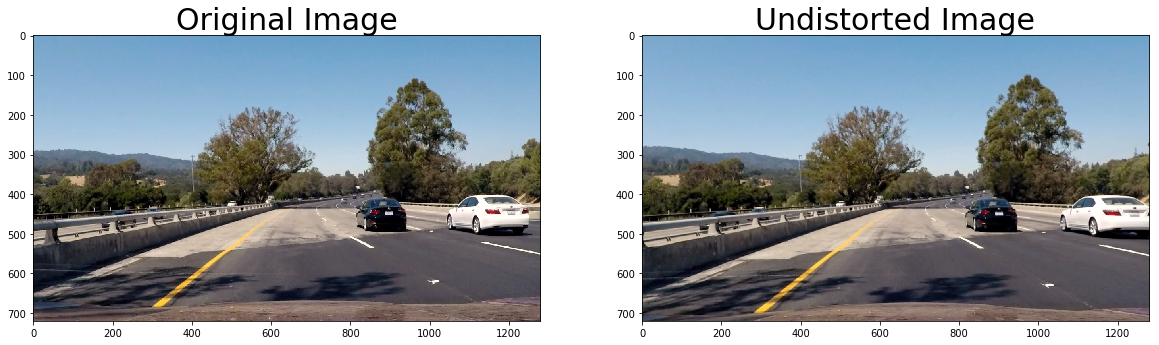

In [5]:
def distortion_corrected_image(img):
    """
    Distortion corrected image
    """  

    # load pickled distortion matrix
    with open('calibration_pickle.p', mode='rb') as f:
        dist_pickle = pickle.load(f)
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

def test_distortion_corrected():
    """
    Test distortion_corrected_image function 
    """
    img = mpimage.imread('test_images/test4.jpg')
    dst = distortion_corrected_image(img)
    
    # Show the original image and undistored img
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    
test_distortion_corrected()
# The images are used in the part 2 pipeline
img = mpimage.imread('test_images/test4.jpg')
undistored_image = distortion_corrected_image(img)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

2. Create a thresholded binary image
</p>

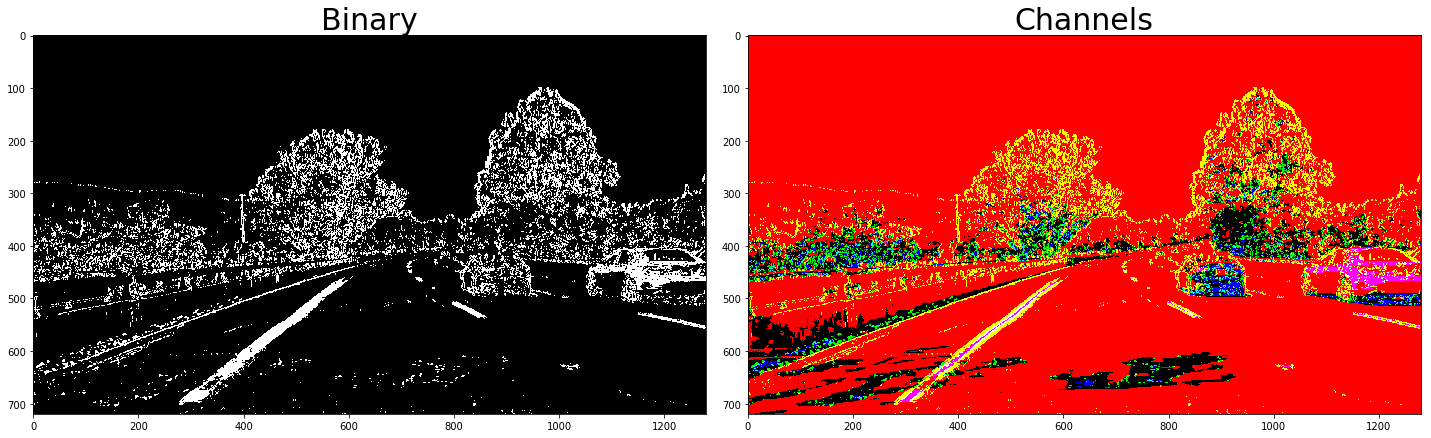

In [6]:
def binary_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), l_thresh=(45,255)):
    """
    Threshhold image on saturation channel and lightness channel
    using gradient x, direction and magnitude  
    """
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Direction threshold
    sobel_kernel = 15
    thresh = (0.7, 1.2)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)# Grayscale
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Magnitude threshold
    sobel_kernel = 9
    mag_thresh = (30, 255)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)# Convert to grayscale
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold L channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Combined sobel, direction and magnitude binary threshold
    combined = np.zeros_like(dir_binary)
    combined[(sxbinary==1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    channels = 255*np.dstack(( l_binary, combined, s_binary)).astype('uint8')        
    binary = np.zeros_like(combined)
    binary[((l_binary == 1) & (s_binary == 1) | (combined==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')
    return channels, binary

def test_threshold_binary():
    """
    Test binary_pipeline function on the undistored_image
    """
    channels, binary = binary_pipeline(undistored_image)
    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()

    ax1.imshow(binary)
    ax1.set_title('Binary', fontsize=30)

    ax2.imshow(channels)
    ax2.set_title('Channels', fontsize=30)

test_threshold_binary()

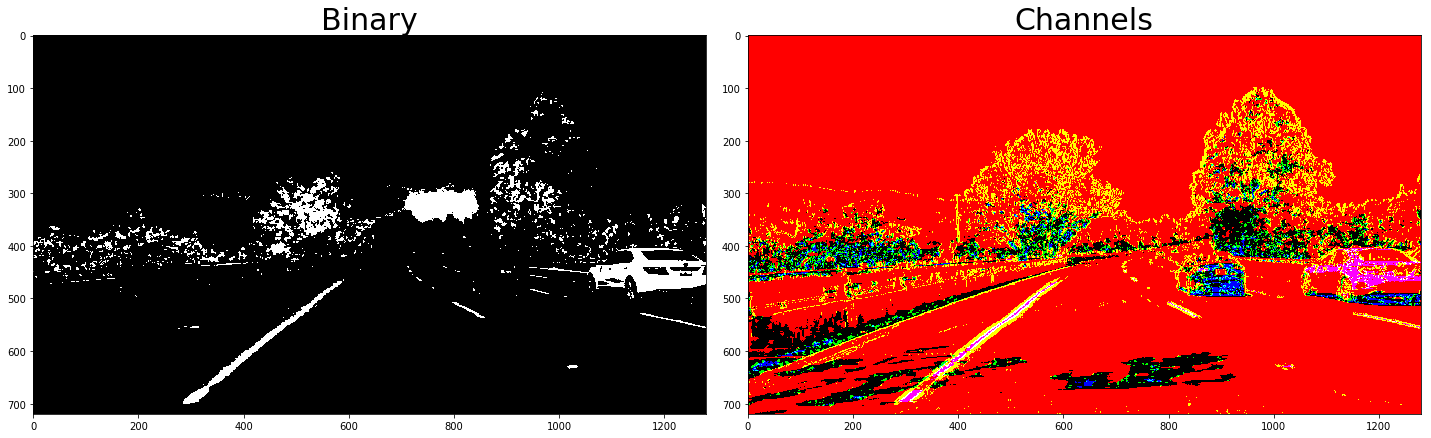

In [7]:
def binary_pipeline_color(img):
    """
    Threshhold image on color mask
    """
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    
    ## White Color
    lower_white_filter = np.array([0,210,0], dtype=np.uint8)
    upper_white_filter = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white_filter, upper_white_filter)
    
    ## Yellow Color
    lower_yellow_filter = np.array([18,0,100], dtype=np.uint8)
    upper_yellow_filter = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow_filter, upper_yellow_filter)  
    
    #convert to binary image
    combined_binary = np.zeros_like(white_mask)    
    combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 255
    combined_binary[(combined_binary == 255)] = 1
    
    return combined_binary

def test_threshold_binary2():
    """
    Test binary_pipeline_color function on the undistored_image
    """
    binary = binary_pipeline_color(undistored_image)
    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()

    ax1.imshow(binary, cmap='gray')
    ax1.set_title('Binary', fontsize=30)

    ax2.imshow(binary_pipeline(undistored_image)[0])
    ax2.set_title('Channels', fontsize=30)

test_threshold_binary2()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

3. Perspective Transformation
</p>

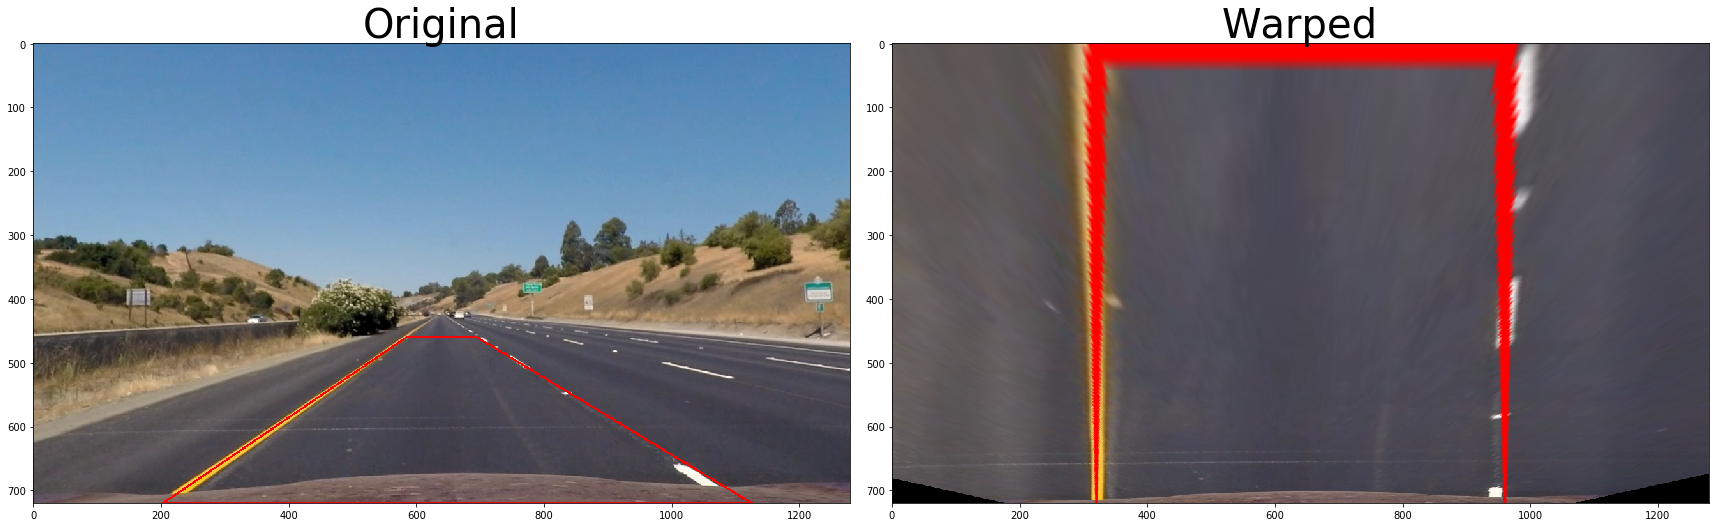

In [8]:
def warper(img, img_size, src, dst):
    """
    Perspective Transformation on the specific image
    """
    
    # Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, Minv, M


def test_warper_straight():
    """
    Test warper function on the straight lines image
    """    
    # Read image
    img = mpimage.imread('test_images/straight_lines1.jpg')
    img = distortion_corrected_image(img)
    img_size = (img.shape[1], img.shape[0])
    
    # Define the source point on the specific region of the image 
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    # Draw a red rectngle on the image
    rect_tuples=[]
    for ind,c in enumerate(src):
        rect_tuples.append(tuple(src[ind]))
    cv2.line(img, rect_tuples[0], rect_tuples[1], color=[255,0,0], thickness=2)
    cv2.line(img, rect_tuples[1], rect_tuples[2], color=[255,0,0], thickness=2)
    cv2.line(img, rect_tuples[2], rect_tuples[3], color=[255,0,0], thickness=2)
    cv2.line(img, rect_tuples[3], rect_tuples[0], color=[255,0,0], thickness=2)
    
    # Perspective Transformation
    offset = 150
    new_top_left=np.array([src[0,0],0])
    new_top_right=np.array([src[3,0],0])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    straight_warpered, _, _ = warper(img, img_size, src, dst)

    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original', fontsize=40)
    ax2.imshow(straight_warpered)
    ax2.set_title('Warped', fontsize=40)

test_warper_straight()

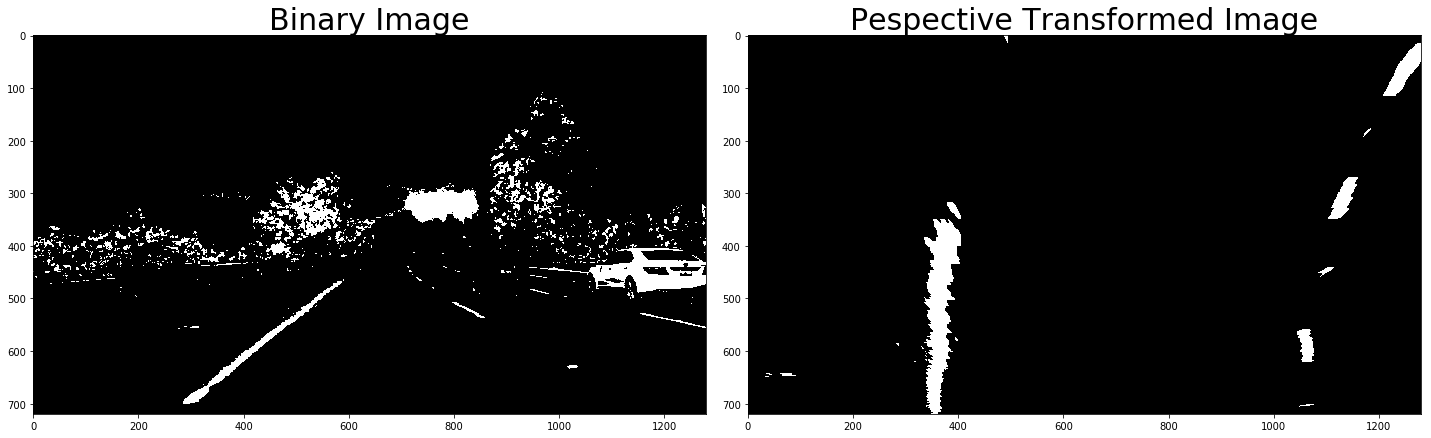

In [9]:
def warper_binary(undistored_img):
    """
    Test warper function on the undistored_image
    """
    binary = binary_pipeline_color(undistored_img)
    
    # Pespective transform on image
    """
    src = np.float32([
    [  588,   446 ],
    [  691,   446 ],
    [ 1126,   720 ],
    [  153 ,   720 ]])
    """
    offset = 200

    src = np.float32([
    [  588,   446 ],
    [  691,   446 ],
    [ 1126,   673 ],
    [  153 ,   673 ]])

    img_size = (binary.shape[1], binary.shape[0])
    dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
    binary_warped, Minv, M = warper(binary, img_size, src, dst)
    
    return binary, binary_warped, Minv, M
    
def show_warper_binary_img():
    """
    Plot the binary warpered image compared with the binary image
    """
    binary, binary_warped,_, _= warper_binary(undistored_image)
    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(binary, cmap='gray')
    ax1.set_title('Binary Image', fontsize=30)
    ax2.imshow(binary_warped, cmap='gray')
    ax2.set_title('Pespective Transformed Image', fontsize=30)
    return binary_warped

show_warper_binary_img()
# Save the binary warped image
_, binary_warped, Minv, M= warper_binary(undistored_image)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

4. Lane Detections
</p>

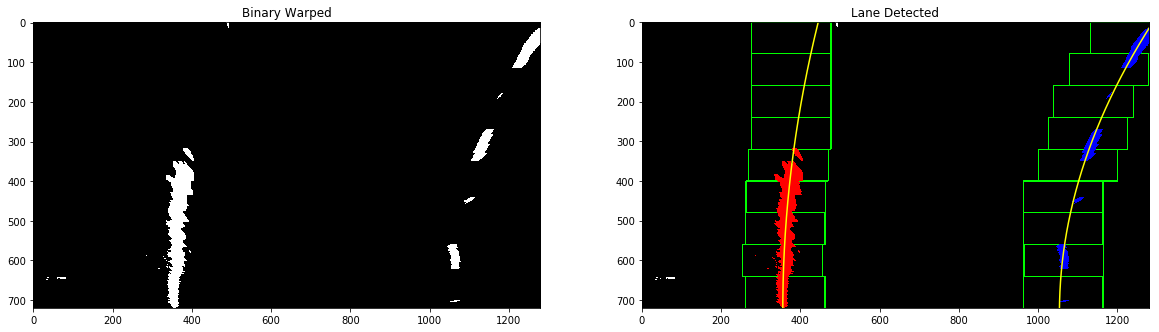

In [10]:
def finding_lines(binary_warped):
    """
    Finding the laneline on the specifical image
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Finding peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    nwindows = 9

    # Height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identifing the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Margin in which to search
    margin = 100

    # Minimum number of pixels found to recenter window
    minpix = 50

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Steping through windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Drawing the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identifing the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Appending these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # Recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenating the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ## Visualization
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return (out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, True)


def visualize_finding_lines(binary_warped):
    """
    Plot the finding lines 
    """
    out_img, ploty, left_fitx, right_fitx, _, _, _= finding_lines(binary_warped)
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(binary_warped, cmap='gray')
    plt.title('Binary Warped')

    plt.subplot(1,2,2)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.title('Lane Detected')


visualize_finding_lines(binary_warped)
# Save the parameters of lane detections
_, ploty, left_fitx, right_fitx, left_fit, right_fit, _= finding_lines(binary_warped)

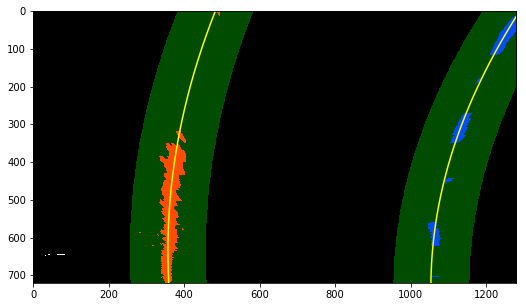

In [11]:
def finding_lines_nextframe(binary_warped_nextframe, left_fit_previos, right_fit_previous):
    """
    Finding the nextframe lane line
    """
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped_nextframe")
    # It's now much easier to find line pixels!
    nonzero = binary_warped_nextframe.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_previos[0]*(nonzeroy**2) + left_fit_previos[1]*nonzeroy + 
                                   left_fit_previos[2] - margin)) & (nonzerox < (left_fit_previos[0]*(nonzeroy**2) + 
                                                                         left_fit_previos[1]*nonzeroy + left_fit_previos[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + 
                                    right_fit_previous[2] - margin)) & (nonzerox < (right_fit_previous[0]*(nonzeroy**2) + 
                                                                           right_fit_previous[1]*nonzeroy + right_fit_previous[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if (leftx.size == 0) or (lefty.size==0) or (rightx.size==0) or (righty.size==0):
        return 0, False
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_nextframe.shape[0]-1, binary_warped_nextframe.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_nextframe, binary_warped_nextframe, binary_warped_nextframe))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                                                    ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                                                     ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return (result,left_fit, right_fit, left_fitx, right_fitx, ploty, True)  

def visualize_finding_lines_nextframe(binary_warped_nextframe, left_fit_previos, right_fit_previous): 
    """
    Plot the next frame lane dectetion image
    """
    result, _, _, left_fitx_nextframe, right_fitx_nextframe, ploty_nextframe, _= finding_lines_nextframe(binary_warped_nextframe, left_fit_previos, right_fit_previous)
    plt.figure(figsize=(10,5))
    plt.imshow(result)
    plt.plot(left_fitx_nextframe, ploty_nextframe, color='yellow')
    plt.plot(right_fitx_nextframe, ploty_nextframe, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

# Assume the 'binary_warped' is the 'binary_warped_nextframe' test the function
visualize_finding_lines_nextframe(binary_warped, left_fit, right_fit)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

5. Measuring Curvature
</p>


<img src="examples/Radius_of_Curvature.jpg" alt="Radius Of Curvature" style="width: 600px;"/>

In [12]:
def measure_curvature(ploty, left_fitx, right_fitx, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    x_dis_pix = (right_fitx[-1] - left_fitx[-1])
    xm_per_pix = 3.7/x_dis_pix # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    print((right_fitx[-1] - left_fitx[-1]))
    print(y_eval)
    
    # Calculate the new radii of curvature    
    left_y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    left_y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    left_curverad = ((1 + left_y1*left_y1)**(1.5))/np.absolute(left_y2)
    
    right_y1 = (2*right_fit[0]*y_eval + right_fit[1])*xm_per_pix/ym_per_pix
    right_y2 = 2*right_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    right_curverad = ((1 + right_y1*right_y1)**(1.5))/np.absolute(right_y2)
    
    aver_curverad = (left_curverad + right_curverad) / 2
    
    return left_curverad, right_curverad, aver_curverad
    
left_curverad, right_curverad, aver_curverad = measure_curvature(ploty, left_fitx, right_fitx, left_fit, right_fit)
# Now our radius of curvature is in meters
print("Radius of Left Curvature: %f" % left_curverad, 'm;', "Radius of Right Curvature: %f" % right_curverad, 'm')
print("Radius of Average Curvature: %f" % aver_curverad, 'm')

698.103217455
719.0
Radius of Left Curvature: 964.698695 m; Radius of Right Curvature: 373.468503 m
Radius of Average Curvature: 669.083599 m


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

6. Plotted back down onto the road 
</p>

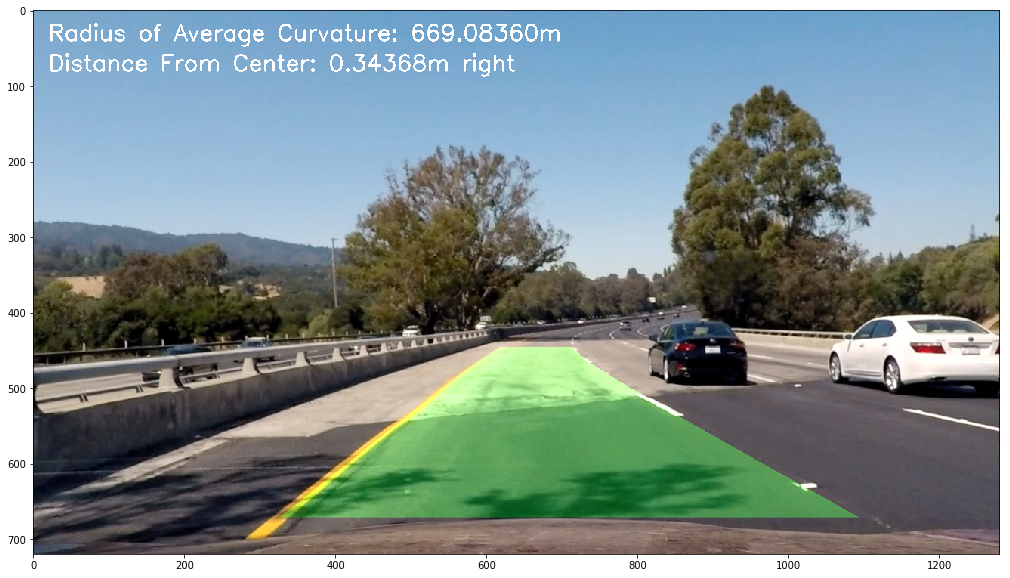

In [13]:
def plotted_back_down(binary_warped, left_fitx, right_fitx, ploty, Minv, undistorted_img, curvature):
    """
    Plotted back down the curvature and distance from center onto the road
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

    cv2.putText(result,'Radius of Average Curvature: %.5fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    x_middle = binary_warped.shape[1] / 2
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/(right_fitx[-1] - left_fitx[-1]) # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Caclulated the position of the vehicle with respect to center
    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - x_middle) * xm_per_pix
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'

    cv2.putText(result,'Distance From Center: %.5fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
  
    return result

def save_prart2_image(result_image):
    """
    Save part2 final result image
    """
    if not os.path.exists('output_images/part2/'):
        os.makedirs('output_images/part2/')
        plt.imsave('output_images/part2/'+'plotted_back_result.jpg',result_image)
    else:
        plt.imsave('output_images/part2/'+'plotted_back_result.jpg',result_image)
    plt.figure(figsize=(20,10))
    plt.imshow(result_image)  

result_image = plotted_back_down(binary_warped, left_fitx, right_fitx, ploty, Minv, undistored_image, aver_curverad)
save_prart2_image(result_image)

<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Part 3: Pipeline (video)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

1. Define a class to receive the characteristics of each line detection
</p>

In [14]:
class Line:
    def __init__(self):
        # The first frame of video has been processed
        self.first_frame_processed = True          
        
        #  The value of left and right line
        self.left_fit = [np.array([False])] 
        self.right_fit = [np.array([False])] 
        #  The deque to store last frame n fits
        self.recent_left_fit = deque([],maxlen=10)
        self.recent_right_fit = deque([],maxlen=10)
        
        # The needed parameters which defined by hotcode
        self.y_eval = 719
        self.midx = 640
        self.ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
        self.curvature = 0
        
       
    def add_fit_left(self, left_fit):
        """
        Add the left fit to the deque
        """ 
        if (len(self.recent_left_fit))<=10:
            self.recent_left_fit.append(left_fit)
        else:
            self.recent_left_fit.leftpop()
            self.recent_left_fit.append(left_fit)
                
    def avg_fit_left(self):
        """
        Average left fits 
        """ 
        fit = np.array(self.recent_left_fit)
        avg_previous_left = fit.mean(axis = 0)
        return avg_previous_left
        
    def add_fit_right(self, right_fit):
        """
        Add the right fit to the deque
        """         
        if (len(self.recent_right_fit))<=10:
            self.recent_right_fit.append(right_fit)
        else:
            self.recent_right_fit.leftpop()
            self.recent_right_fit.append(right_fit)

    def avg_fit_right(self):
        """
        Average right fits 
        """         
        fit = np.array(self.recent_right_fit)
        avg_previous_right = fit.mean(axis = 0)
        return avg_previous_right            
        
    
    def update_bilateral_fits(self, left_fit, right_fit):
        """
        Update cofficient of bilateral fitting polynomial
        """ 
        
        if self.first_frame_processed:   
            # The first frame set the values directly
            self.right_fit = right_fit
            self.left_fit = left_fit
            self.recent_left_fit.append(left_fit)
            self.recent_right_fit.append(right_fit)            
        else:
            # Sanity check by MSE 
            # Now, the self value is the previous frame values, then the left_fit and right_fit are current frame values
            left_error = ((self.left_fit[0] - left_fit[0]) ** 2).mean(axis=None)      
            right_error = ((self.right_fit[0] - right_fit[0]) ** 2).mean(axis=None)   
            
            # If the polynomial parameter succeed, adding it to deque and set average value
            # Othervise, using the average current  polynomial values to assign to the self 
            if left_error < 0.01:
                self.add_fit_left(left_fit)
                self.left_fit = self.avg_fit_left()
            else:
                self.left_fit = left_fit
            
            if right_error < 0.01:
                self.add_fit_right(right_fit)
                self.right_fit = self.avg_fit_right()
            else:
                self.right_fit = right_fit       
        
        # update curvature
        self.update_curvature(self.right_fit, self.left_fit)
     
     
    def update_curvature(self, left_fit, right_fit):
        """
        Update radius of curvature 
        """
        #  Calculate the curvature
        y_eval = self.y_eval
        xm_per_pix = self.xm_per_pix
        ym_per_pix = self.ym_per_pix
        # Calculate the new radii of curvature    
        left_y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
        left_y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
        left_curverad = ((1 + left_y1*left_y1)**(1.5))/np.absolute(left_y2)
    
        right_y1 = (2*right_fit[0]*y_eval + right_fit[1])*xm_per_pix/ym_per_pix
        right_y2 = 2*right_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
        right_curverad = ((1 + right_y1*right_y1)**(1.5))/np.absolute(right_y2)
        
        curvature = (left_curverad + right_curverad) / 2
        
        self.curvature = curvature
        

    def get_position_from_center(self):
        """
        Get position from the center 
        """        
        #  Calculate the curvature position from center
        x_left_pix = self.left_fit[0]*(self.y_eval**2) + self.left_fit[1]*self.y_eval + self.left_fit[2]
        x_right_pix = self.right_fit[0]*(self.y_eval**2) + self.right_fit[1]*self.y_eval + self.right_fit[2]
        
        return ((x_left_pix + x_right_pix)/2.0 - self.midx) * self.xm_per_pix  

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

2. Define a Class Pipeline to process the video
</p>

In [15]:
class Pipeline:
    line = None
    M = None
    Minv = None
    cameraMat = None
    distCoeffs = None
    
    
    @staticmethod
    def set_values(l, m, minv):
        Pipeline.line = l
        Pipeline.M = m
        Pipeline.Minv = minv

    @staticmethod
    def pipeline(img):
        line, M, Minv = Pipeline.line, Pipeline.M, Pipeline.Minv
        if (line is None or M is None or Minv is None):
            print("Error None Pipe line")
            return False
        
        ### Pipe line to process the video
        
        ### Step1:distortion
        ### Step2: threshold and binary
        ### Step3: perspective transform
        img_size = (img.shape[1], img.shape[0])
        width, height = img_size
        img = distortion_corrected_image(img)
        _, binary_warped, _, _= warper_binary(img)
        
        ### Step 4: lane dectection
        ### Step 5: update fit cofficients and calculated the radius of curvature of the lane 
        # and the position of the vehicle with respect to center.
        nwindows = 9
        window_height = np.int(binary_warped.shape[0]/nwindows)
        margin = 100
        minpix = 50
        
        if line.first_frame_processed:
            # The fisrst frame
            # Finding the lane line Used Sliding Window
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            leftx_current = leftx_base
            rightx_current = rightx_base

            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            line.update_bilateral_fits(left_fit, right_fit)

            line.first_frame_processed = False
     
        else:
            # Not the first frame
            # Finding the lane lane by pervious fit parameters
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            left_fit = line.left_fit
            right_fit = line.right_fit
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            #### Exception handling
            if (leftx.size == 0) or (lefty.size==0) or (rightx.size==0) or (righty.size==0):
                line.update_bilateral_fits(line.left_fit, line.right_fit)
            else:
                line.update_bilateral_fits(np.polyfit(lefty, leftx, 2), np.polyfit(righty, rightx, 2))
            left_fit = line.left_fit
            right_fit = line.right_fit           
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        ### Step 6: plotted back down to the frame image
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        
        # Add Radius of Curvature
        cv2.putText(result,'Radius of Average Curvature: %.5fm' % line.curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
        # Add distance from center
        position_from_center = line.get_position_from_center()
        if position_from_center < 0:
            text = 'left'
        else:
            text = 'right'
        cv2.putText(result,'Distance From Center: %.5fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
        return result

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

3. Process the Video
</p>

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line=Line()
Pipeline.set_values(line, M, Minv)

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Pipeline.pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
    

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:51<00:00, 11.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 1min 51s


In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line=Line()
Pipeline.set_values(line, M, Minv)

white_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(Pipeline.pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:38<00:00, 12.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 39.5 s


In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line=Line()
Pipeline.set_values(line, M, Minv)

white_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(Pipeline.pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [01:57<00:00, 10.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 1min 58s
